In [24]:
!pip install scikit-learn

In [168]:
"""
custom implementation of kde for conditional sampling
of multidimensional distributions
"""

from __future__ import division, print_function, absolute_import
import numpy as np
import pandas as pd
import math
from scipy.stats import gaussian_kde as scipy_gaussian_kde
from numpy.random import multivariate_normal
# The scipy KDTree does not allow for 'seuclidean' distance metric
# so we will use the BallTree class instead.
from sklearn.neighbors import BallTree
import warnings

In [169]:
__all__ = ('gaussian_kde')
__author__ = ('Duncan Campbell')


class gaussian_kde(scipy_gaussian_kde):
    """
    a gaussian kde class with an additional method to allow
    for approximate conditional sampling of the pdf based on
    the scipy.stats.gaussian_kde class

    Representation of a kernel-density estimate using Gaussian kernels.
    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.

    d : int
        Number of dimensions.

    n : int
        Number of datapoints.

    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.

    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).

    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    evaluate
    __call__
    integrate_gaussian
    integrate_box_1d
    integrate_box
    integrate_kde
    pdf
    logpdf
    resample
    set_bandwidth
    covariance_factor
    conditional_sample

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.
    Scott's Rule [1]_, implemented as `scotts_factor`, is::
        n**(-1./(d+4)),
    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::
        (n * (d + 2) / 4.)**(-1. / (d + 4)).
    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    ...     "Measurement model, return two coupled measurements."
    ...     m1 = np.random.normal(size=n)
    ...     m2 = np.random.normal(scale=0.5, size=n)
    ...     return m1+m2, m1-m2
    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots()
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()
    """

    def __init__(self, dataset, bw_method=None):
        """
        """
        super(gaussian_kde, self).__init__(dataset, bw_method=bw_method)

    def conditional_sample(self, x, c):
        """
        Return random samples from the distribution :math:`P(y|x)`,
        where :math:`x` and :math:`y` are subsets of the full N-dimensional
        space of the pdf obtained from KDE.  Here :math:`x` is assumed to
        have dimension q and :math:`y` N-q.

        Parameters
        ----------
        x : array_like
            an array of dependent variables of shape (q, n_samples)

        c : array_like
            boolean array defining the conditional dimensions.
            the shape must be (N,)

        Returns
        -------
        y : numpy.array
            array of sampled values of shape (N-q, n_samples)

        Notes
        -----
        This is only an approximate method.  A more robust method
        would be to calculate the full conditional distribution for
        each `x` using a different KDE method.
        """

        x = np.atleast_1d(x)
        c = np.atleast_1d(c)
        size = len(x)

        if x.ndim == 1:
            x = x[..., np.newaxis]

        # find the nearest neighbor to each x.
        V = np.diagonal(self.covariance)
        d = self.dataset.T
        tree = BallTree(d[:, c], metric='seuclidean', V=V[c])

        # add a random variable to each x.
        mask = np.ix_(c, c)
        cov_xx = np.atleast_2d(self.covariance[mask])
        dim_x = np.sum(c)
        x = x + multivariate_normal(np.zeros((dim_x,), float),
                                    cov_xx, size=size)

        # return index into training sample and the normalized distance.
        d, indices = tree.query(x, k=1, return_distance=True)

        # if the training dataset does not span the range of `x`,
        # then this may not be the best algorithm to use.
        if np.max(d) > 3.0:
            msg = ("Training dataset may not be suffucient \n"
                   "to sample over the range of `x`. \n"
                   "The maximum normalzed distance is: {0}".format(np.max(d)))
            warnings.warn(msg)

        # for each matched point in the training dataset
        # add a random variable get a sample for y.
        mask = np.ix_(~c, ~c)
        cov_yy = np.atleast_2d(self.covariance[mask])
        dim_y = self.d - np.sum(c)
        norm = multivariate_normal(np.zeros((dim_y,), float),
                                   cov_yy, size=size)
        means = self.dataset[~c, indices]

        return means + norm

In [170]:
from scipy import stats
def measure(n):
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

In [171]:
import numpy as np
import matplotlib.pyplot as plt

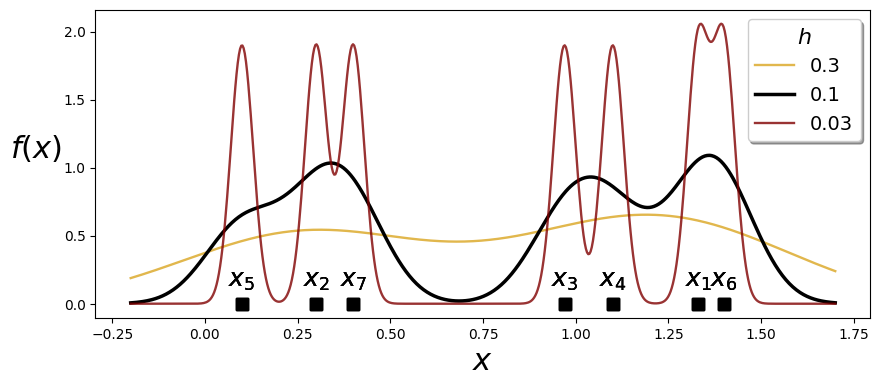

In [172]:
# the Kernel function
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dummy dataset
dataset = np.array([1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4])

# x-value range for plotting KDEs
x_range = np.linspace(dataset.min()-0.3, dataset.max()+0.3, num=600)

# bandwith values for experimentation
H = [0.3, 0.1, 0.03]
n_samples = dataset.size

# line properties for different bandwith values
color_list = ['goldenrod', 'black', 'maroon']
alpha_list = [0.8, 1, 0.8]
width_list = [1.7,2.5,1.7]

plt.figure(figsize=(10,4))
# iterate over bandwith values
for h, color, alpha, width in zip(H, color_list, alpha_list, width_list):
    total_sum = 0
    # iterate over datapoints
    for i, xi in enumerate(dataset):
        total_sum += K((x_range - xi) / h)
        plt.annotate(r'$x_{}$'.format(i+1),
                     xy=[xi, 0.13],
                     horizontalalignment='center',
                     fontsize=18,
                    )
    y_range = total_sum/(h*n_samples)
    plt.plot(x_range, y_range, 
             color=color, alpha=alpha, linewidth=width, 
             label=f'{h}')

    plt.plot(dataset, np.zeros_like(dataset) , 's', 
             markersize=8, color='black')
    
plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=20)
plt.legend(fontsize=14, shadow=True, title='$h$', title_fontsize=16)
plt.show()

In [30]:
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dataset
data = pd.read_excel('ForAgeCalc.xlsx', usecols=['RNHW']).dropna()
data = pd.to_numeric(data['RNHW'])

# x-value range for plotting KDEs
x_range = np.linspace(0,3000,1000)

# iterate over bandwidth values
def kde_new(info, h, the_color, the_alpha, title):
    total_sum = np.zeros_like(x_range)
    for i, xi in enumerate(data):
        total_sum += K((x_range - xi) / h)
    y_range = total_sum/(h*len(data))
    plt.plot(x_range, y_range, color=the_color)
    plt.fill_between(x_range, y_range, color=the_color, alpha=the_alpha)
    plt.xlabel('Age (Ma)')
    plt.ylabel('Density')
    plt.title(title)
    plt.show()

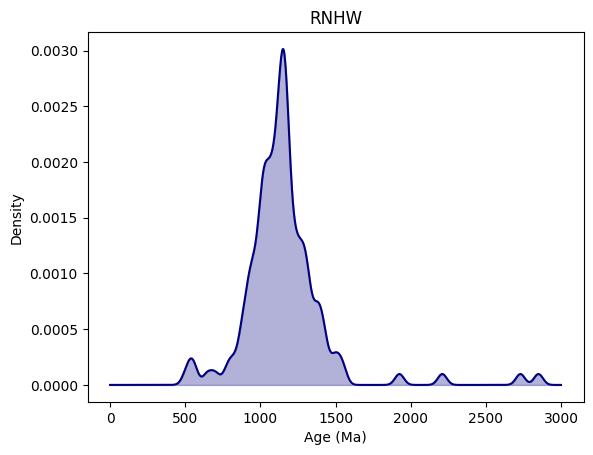

In [31]:
kde_new(data, 30, 'navy', 0.3, 'RNHW')

Text(0.5, 1.0, 'Gilder GS-11')

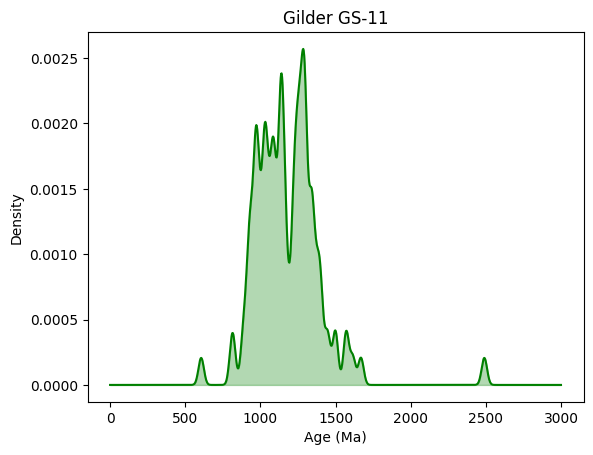

In [32]:
forAgeCalcdf = pd.read_excel('ForAgeCalc.xlsx', usecols=['Gilder GS-11'])
data = forAgeCalcdf['Gilder GS-11'].dropna()
kde = gaussian_kde(data, bw_method=0.08)
x_vals = np.linspace(0, 3000, 1000)
density = kde(x_vals)
plt.plot(x_vals, density, color='green')
plt.fill_between(x_vals, density, color='green', alpha=0.3)
plt.xlabel('Age (Ma)')
plt.ylabel('Density')
plt.title('Gilder GS-11')

In [33]:
forAgeCalcdf = pd.read_excel('ForAgeCalc.xlsx', usecols=['Gilder GS-11'])
forAgeCalcdf2 = pd.read_excel('ForAgeCalc.xlsx', usecols=['RNHW'])
forAgeCalcdf3 = pd.read_excel('ForAgeCalc.xlsx', usecols=['RNHE'])
forAgeCalcdf4 = pd.read_excel('ForAgeCalc.xlsx', usecols=['NY14-TAP-22'])
forAgeCalcdf5 = pd.read_excel('ForAgeCalc.xlsx', usecols=['E79'])
forAgeCalcdf6 = pd.read_excel('ForAgeCalc.xlsx', usecols=['PB'])
forAgeCalcdf7 = pd.read_excel('ForAgeCalc.xlsx', usecols=['FL3'])

In [34]:
def kde_function(dataFrame, colName, bw, the_color, the_alpha, lower, upper, nums, title):
    data = dataFrame[colName].dropna()
    kde = gaussian_kde(data, bw_method=bw)
    x_vals = np.linspace(lower, upper, nums)
    density = kde(x_vals)
    plt.plot(x_vals, density, color=the_color)
    plt.fill_between(x_vals, density, color=the_color, alpha=the_alpha)
    plt.xlabel('Age (Ma)')
    plt.ylabel('Density')
    plt.title(title)

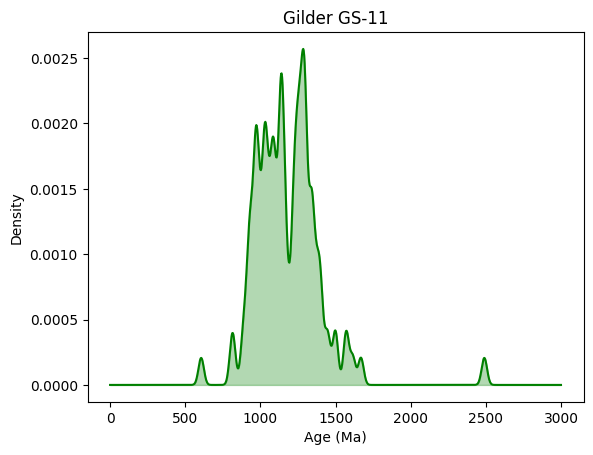

In [35]:
kde_function(forAgeCalcdf, 'Gilder GS-11', 0.08, 'green', 0.3, 0, 3000, 1000, 'Gilder GS-11')

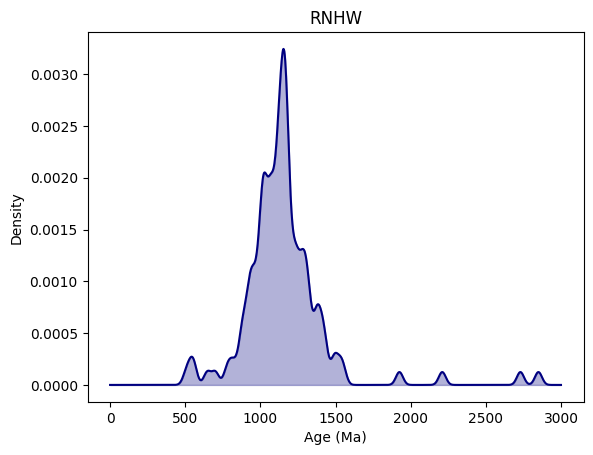

In [36]:
kde_function(forAgeCalcdf2, 'RNHW', 0.08, 'navy', 0.3, 0, 3000, 1000, 'RNHW')

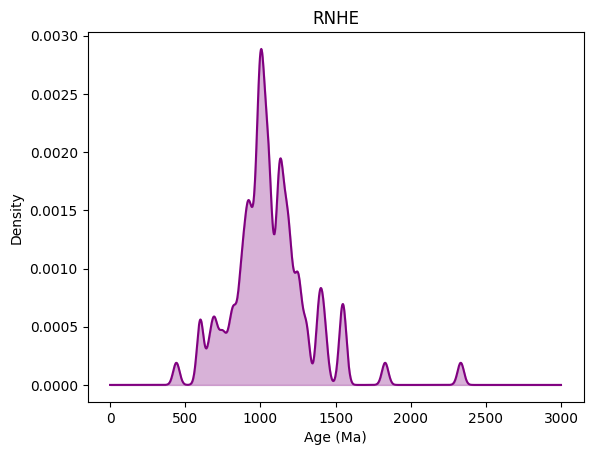

In [37]:
kde_function(forAgeCalcdf3, 'RNHE', 0.08, 'purple', 0.3, 0, 3000, 1000, 'RNHE')

Text(0.5, 1.0, 'Gilder GS-11')

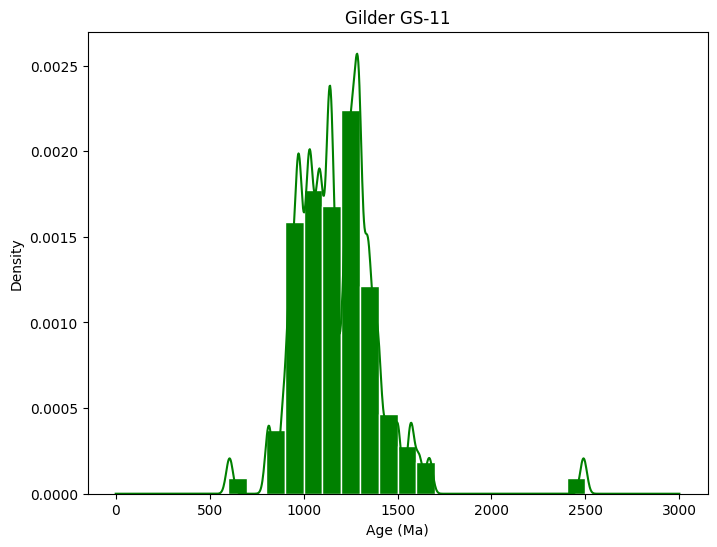

In [38]:
forAgeCalcdf = pd.read_excel('ForAgeCalc.xlsx', usecols=['Gilder GS-11'])
data = forAgeCalcdf['Gilder GS-11'].dropna()

kde = gaussian_kde(data, bw_method=0.08)
x_vals = np.linspace(0, 3000, 1000)
density = kde(x_vals)

fig,ax = plt.subplots(figsize=(8,6))
ax.hist(forAgeCalcdf['Gilder GS-11'], color='green', edgecolor='white', bins=range(0,3000,100), density=True)
ax.plot(x_vals, density, color='green')
plt.xlabel('Age (Ma)')
plt.ylabel('Density')
plt.title('Gilder GS-11')

In [39]:
df = pd.read_excel('ForAgeCalc.xlsx').dropna()
column_list = df.columns.tolist()
print(column_list)

['Gilder GS-11', 'Gilder GS-11 Error', 'RNHW', 'RNHW Error', 'RNHE', 'RNHE Error', 'NY14-TAP-22', 'NY14-TAP-22 Error', 'E79', 'E79 Error', 'PB', 'PB Error', 'FL3', 'FL3 Error']


In [40]:
newList = []
for column in column_list:
    if 'Error' not in column:
        newList.append(column)

In [41]:
print(newList)

['Gilder GS-11', 'RNHW', 'RNHE', 'NY14-TAP-22', 'E79', 'PB', 'FL3']


In [42]:
[column for column in column_list if 'Error' not in column]

['Gilder GS-11', 'RNHW', 'RNHE', 'NY14-TAP-22', 'E79', 'PB', 'FL3']

In [43]:
df = pd.read_excel('ForAgeCalc.xlsx').dropna()
column_list = df.columns.tolist()
newList = [column for column in column_list if 'Error' not in column]
print(newList)

['Gilder GS-11', 'RNHW', 'RNHE', 'NY14-TAP-22', 'E79', 'PB', 'FL3']


In [44]:
data = df['Gilder GS-11']
print(data)

0      606.0
1      810.0
2      820.0
3      881.0
4      895.0
       ...  
93    1376.0
94    1383.0
95    1396.0
96    1402.0
97    1404.0
Name: Gilder GS-11, Length: 98, dtype: float64


In [45]:
def kde_hist_grapher(file_name, width, height, bw, lower, upper, nums, num_bins, color_list, hist_input, kde_input):
    # Creates a pandas data frame from an excel file and a specified column
    df = pd.read_excel(file_name)
    # Creates a list of the columns in the data frame
    column_list = df.columns.tolist()
    # List comprehension creating a list of the non-error columns in the data frame
    new_list = [column for column in column_list if 'Error' not in column]
    # Provides length of newList; used later on during plotting
    num_samples = len(new_list)

    # Joins corresponding values in newList and colorList and iterates through them
    for column, the_color in zip(new_list, color_list):
        # Eliminates all NaN entries in a specified column of the data frame
        data = df[column].dropna()
        # Arranges data into a KDE object that is used to create arrays necessary to plot the KDE
        kde = gaussian_kde(data, bw_method=bw)
        x_vals = np.linspace(lower, upper, nums)
        density = kde(x_vals)
        
        # Sets up subplots and specifies their size
        fig,ax = plt.subplots(figsize=(width, height/num_samples))
        # Plots histogram and KDE
        if hist_input == True and kde_input == True:
            ax.hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax.plot(x_vals, density, color=the_color)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only KDE
        elif kde_input == True:
            ax.plot(x_vals, density, color=the_color)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only histogram
        elif hist_input == True:
            ax.hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
            
    # Labels the x-axis
    plt.xlabel('Age (Ma)')

In [81]:
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def kde_og(file_name, width, height, h, lower, upper, nums, num_bins, color_list):
    # Creates a pandas data frame from an excel file and a specified column
    df = pd.read_excel(file_name)
    # Creates a list of the columns in the data frame
    column_list = df.columns.tolist()
    # List comprehension creating a list of the non-error columns in the data frame
    new_list = [column for column in column_list if 'Error' not in column]
    # Provides length of new_list; used later on during plotting
    num_samples = len(new_list)

    # Joins corresponding values in new_list and error_list and iterates through them
    for column, the_color in zip(new_list, color_list):
        # Eliminates all NaN entries in a specified column of the data frame
        data = df[column].dropna()
        # Creates an array of evenly spaced numbers over a specified interval
        x_vals = np.linspace(lower, upper, nums)
        # Returns an all-zero array with the same shape and data type as the input
        total_sum = np.zeros_like(x_vals)
        # Sets up subplots and specifies their size
        fig,ax = plt.subplots(figsize=(width, height/num_samples))

        # Iterates through index numbers and values in the enumerated data of a column
        # xi is a component of the KDE function
        for i, xi in enumerate(data):
            # Puts asdf
            # Adds the result of this calculation to the array in total_sum
            total_sum += K((x_vals - xi) / h)
        # Completes the KDE function by dividing total_sum by h times the number of data points in the column
        y_vals = total_sum/(h*len(data))
        # Plots KDE
        ax.plot(x_vals, y_vals, color=the_color)

    # Labels x-axis
    plt.xlabel('Age (Ma)')
    # Displays final graphs
    plt.show()

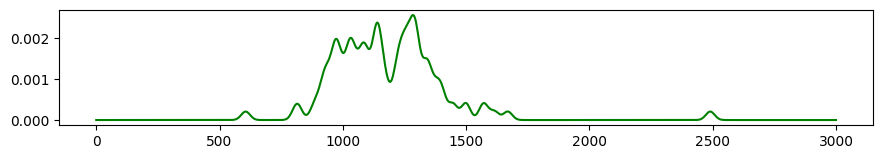

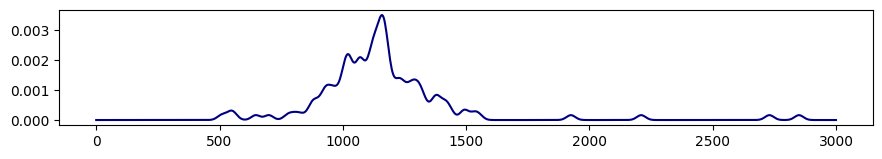

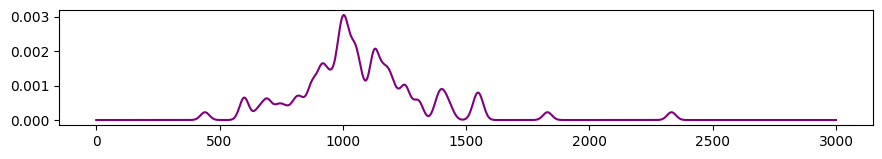

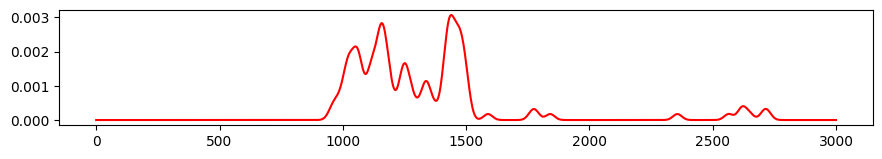

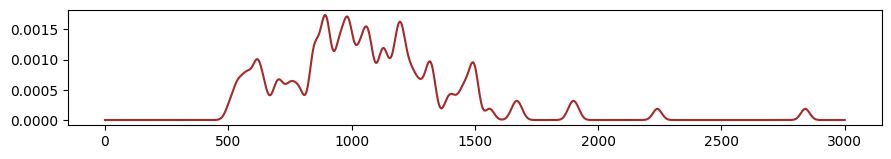

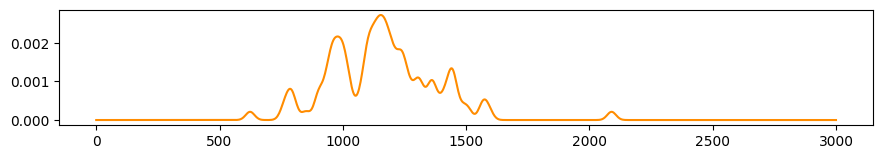

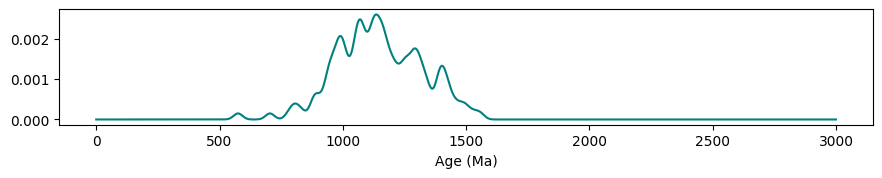

In [82]:
kde_og('ForAgeCalc.xlsx', 10.5, 10.5, 18, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'])

In [177]:
def K_old(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def kde_func(file_name, width, height, c, lower, upper, nums, num_bins, color_list, hist_input, kde_input):
    # Creates a pandas data frame from an excel file and a specified column
    df = pd.read_excel(file_name)
    # Creates a list of the columns in the data frame
    column_list = df.columns.tolist()
    # List comprehension creating a list of the non-error columns in the data frame
    new_list = [column for column in column_list if 'Error' not in column]
    # List comprehension creating a list of the error columns in the data frame
    error_list = [column for column in column_list if 'Error' in column]
    # Provides length of new_list; used later on during plotting
    num_samples = len(new_list)

    # Joins corresponding values in new_list, color_list, and error_list and iterates through them
    for column, the_color, error_col in zip(new_list, color_list, error_list):
        # Eliminates all NaN entries in a specified non-error column of the data frame
        data = df[column].dropna()
        # Eliminates all NaN entries in a specified error column of the data frame
        errors = df[error_col].dropna()
        # Finds the maximum value of the error values in error_list
        error_max = max(errors)
        # Creates an array of evenly spaced numbers over a specified interval
        x_vals = np.linspace(lower, upper, nums)
        # Returns an all-zero array with the same shape and data type as the input
        total_sum = np.zeros_like(x_vals)
        # Sets up subplots and specifies their size
        fig,ax = plt.subplots(figsize=(width, height/num_samples))
    
        # Joins corresponding xi and e values in data and errors and iterates through them
        for xi, e in zip(data, errors):
            # Sets the bandwidth (h) equal to the square root of error_max times by a c-value slightly greater than 1
            # squared minus e squared
            h = np.sqrt((c*error_max)**2 - (e)**2)
            # Runs x_vals - xi divided by h through the previously defined KDE function
            # Adds the result of this calculation to the array in total_sum
            total_sum += K((x_vals - xi) / h)
        # Completes the KDE function by dividing total_sum by h times the number of data points in the column
        y_vals = total_sum/(h*len(data))
    
        # Plots histogram and KDE
        if hist_input == True and kde_input == True:
            ax.plot(x_vals, y_vals, color=the_color)
            ax.hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only KDE
        elif kde_input == True:
            ax.plot(x_vals, y_vals, color=the_color)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only histogram
        elif hist_input == True:
            ax.hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax.set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)

    # Labels x-axis
    plt.xlabel('Age (Ma)')
    # Displays final graphs
    plt.show()

In [237]:
def K(x, xi, h):
    return np.exp(-0.5*((x - xi)**2) / (h**2))* (1/h*np.sqrt(2*np.pi))

def kde_calc_plot(file_name, width, height, c, lower, upper, nums, num_bins, color_list, hist_input, kde_input, save=False):
     # Creates a pandas data frame from an excel file and a specified column
    df = pd.read_excel(file_name)
    # Creates a list of the columns in the data frame
    column_list = df.columns.tolist()
    # List comprehension creating a list of the non-error columns in the data frame
    new_list = [column for column in column_list if 'Error' not in column]
    # List comprehension creating a list of the error columns in the data frame
    error_list = [column for column in column_list if 'Error' in column]
    # Provides length of new_list; used later on during plotting
    num_samples = len(new_list)
    fig, ax = plt.subplots(len(new_list), 1, figsize=(width, height))
    counter = 0
    
    # Joins corresponding values in new_list, color_list, and error_list and iterates through them
    for column, the_color, error_col in zip(new_list, color_list, error_list):
        mask = ~np.isnan(df[column]) & ~np.isnan(df[error_col])
        # Eliminates all NaN entries in a specified non-error column of the data frame
        data = df[column][mask]
        # Eliminates all NaN entries in a specified error column of the data frame
        errors = df[error_col][mask]
        # Finds the maximum value of the error values in error_list
        error_max = max(errors)
        # Creates an array of evenly spaced numbers over a specified interval
        x_vals = np.linspace(lower, upper, nums)
        # Returns an all-zero array with the same shape and data type as the input
        total_sum = np.zeros_like(x_vals)
        # Sets up subplots and specifies their size
    
        # Joins corresponding xi and e values in data and errors and iterates through them
        for xi, e in zip(data, errors):
            # Sets the bandwidth (h) equal to the square root of error_max times by a c-value slightly greater than 1
            # squared minus e squared
            h = np.sqrt((c*error_max)**2 - (e)**2)
            # Runs x_vals - xi divided by h through the previously defined KDE function
            # Adds the result of this calculation to the array in total_sum
            total_sum += K(x_vals, xi, h)
        # Completes the KDE function by dividing total_sum by h times the number of data points in the column
        y_vals = total_sum/len(data)

        # Plots histogram and KDE
        if hist_input == True and kde_input == True:
            ax[counter].plot(x_vals, y_vals, color='black')
            ax[counter].hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax[counter].set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only KDE
        elif kde_input == True:
            ax[counter].plot(x_vals, y_vals, color=the_color)
            ax[counter].set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)
        # Plots only histogram
        elif hist_input == True:
            ax[counter].hist(df[column], color=the_color, edgecolor='white', bins=range(lower, upper, num_bins), density=True)
            ax[counter].set_title(column + " (n = " + str(len(data)) + ")", x=width/12.35, y=height/21)

        counter += 1

    # Labels x-axis
    plt.xlabel('Age (Ma)')
    # Displays final graphs
    
    if save == True:
        print('working')
        plt.savefig('c-'+str(c).split('.')[1]+'.png', dpi=400, bbox_inches='tight')

    plt.show()

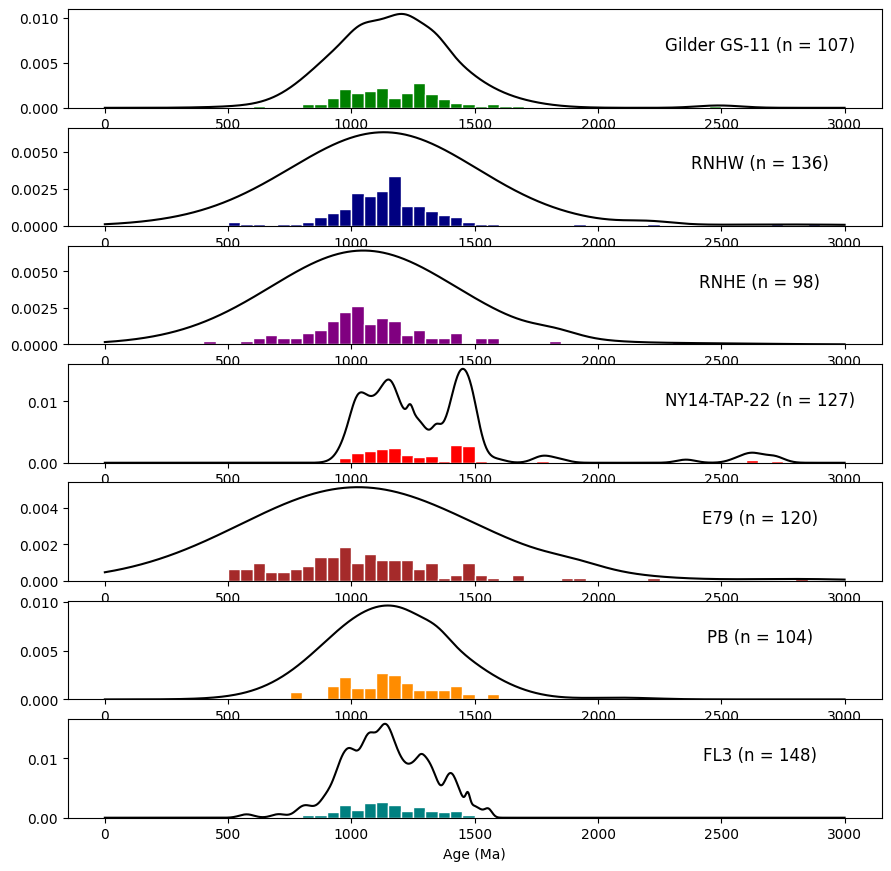

In [238]:
# kde_func call
kde_plot = kde_calc_plot('ForAgeCalc.xlsx', 10.5, 10.5, 1.04, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], True, True)

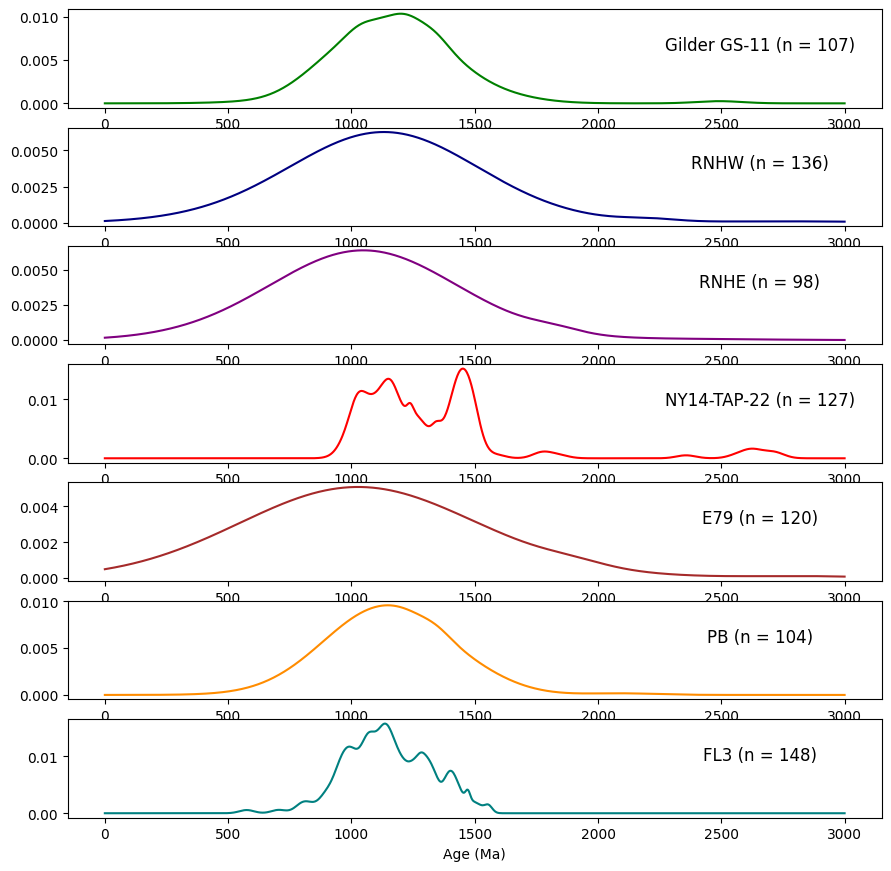

In [215]:
# kde_func call with c = 1.1
kde_calc_plot('ForAgeCalc.xlsx', 10.5, 10.5, 1.05, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], False, True)

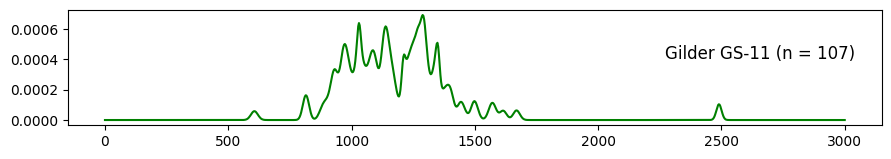

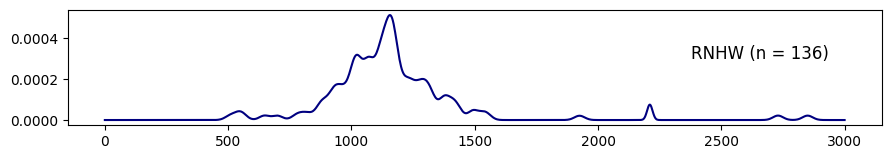

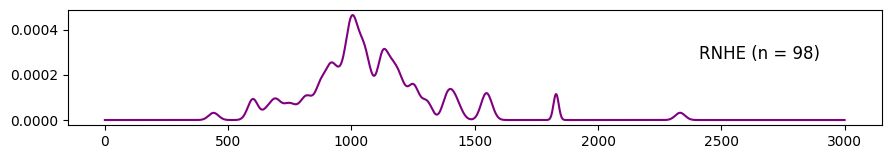

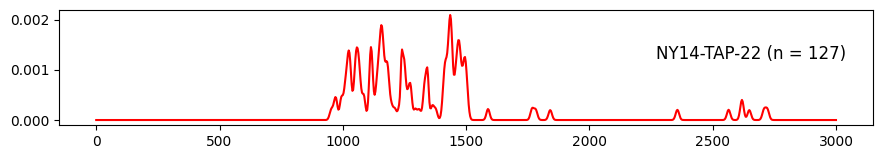

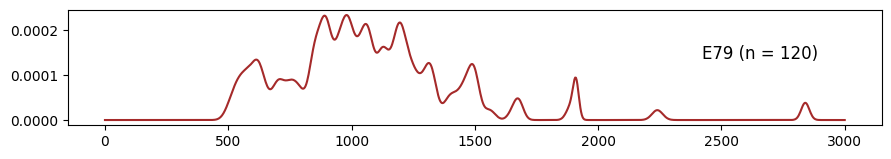

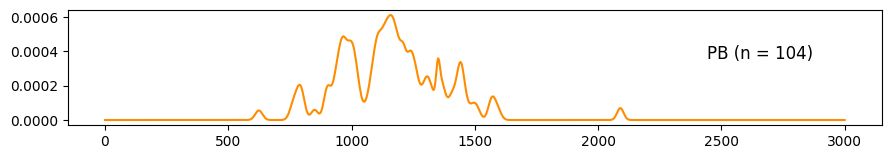

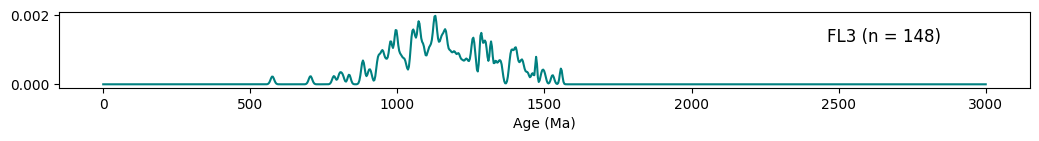

In [161]:
# kde_func call with c = 1.04
kde_calc_yay('ForAgeCalc.xlsx', 10.5, 10.5, 1.04, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], False, True)

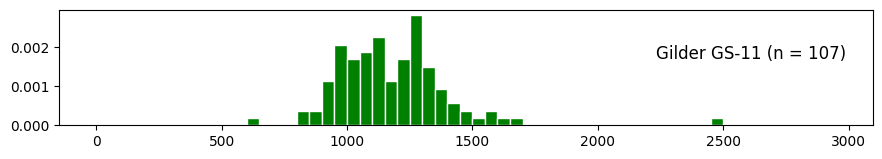

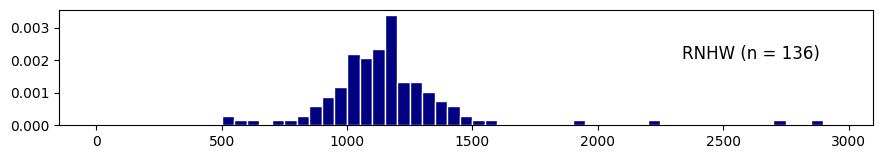

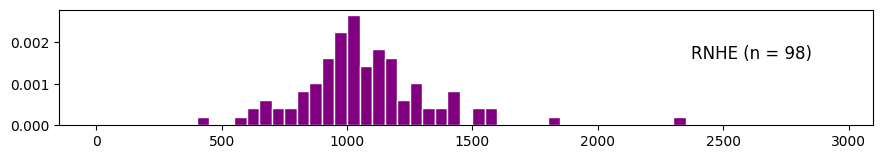

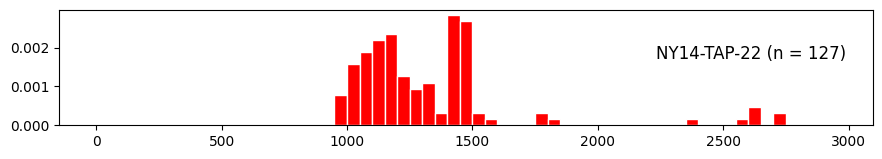

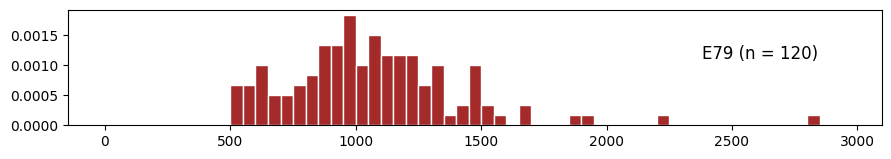

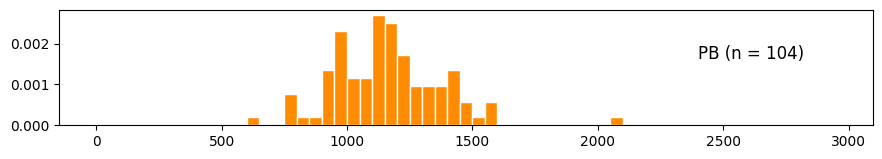

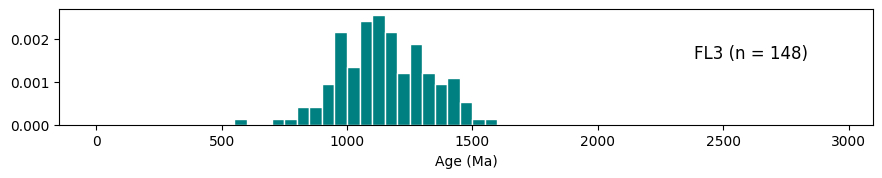

In [162]:
# kde_func call with c = 1.2
kde_calc_plot('ForAgeCalc.xlsx', 10.5, 10.5, 1.2, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], True, False)

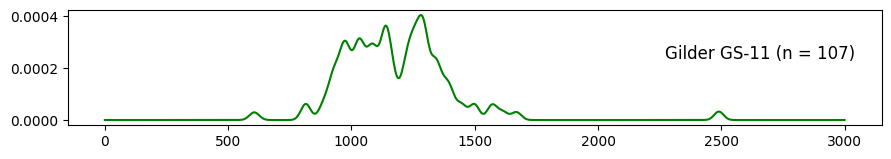

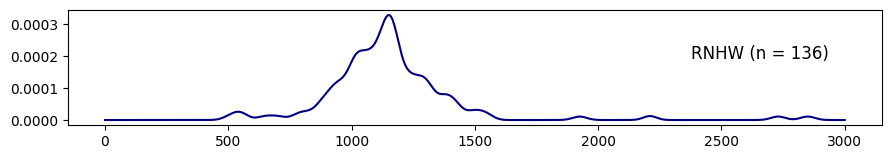

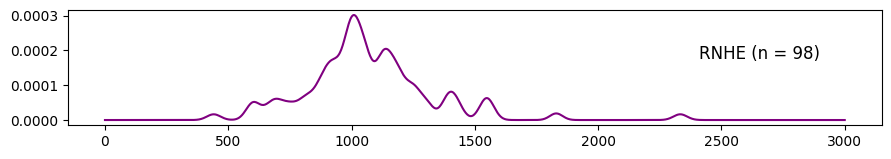

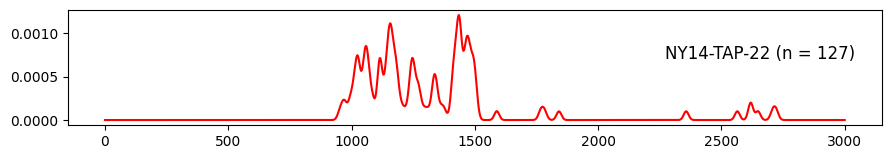

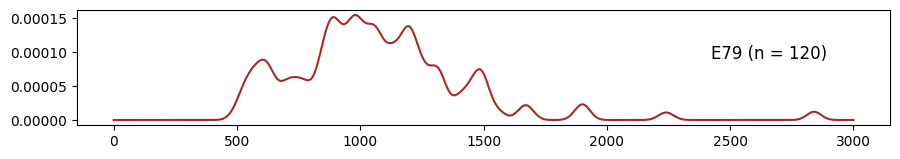

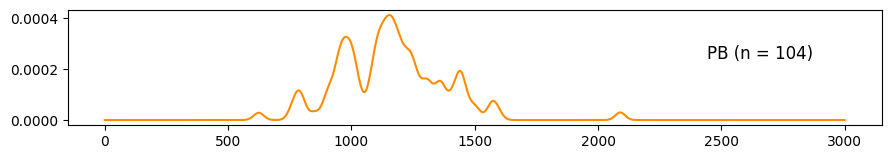

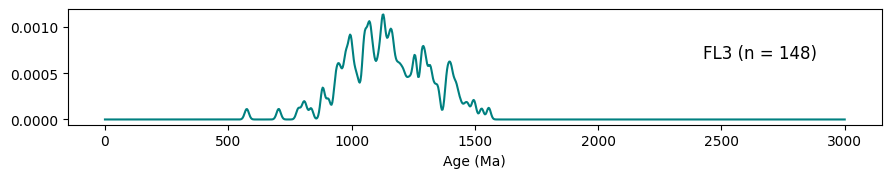

In [163]:
# kde_func call with c = 2
kde_calc_plot('ForAgeCalc.xlsx', 10.5, 10.5, 2, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], False, True)

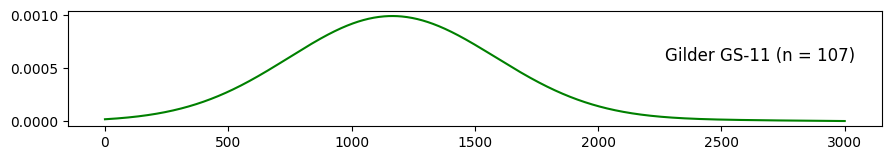

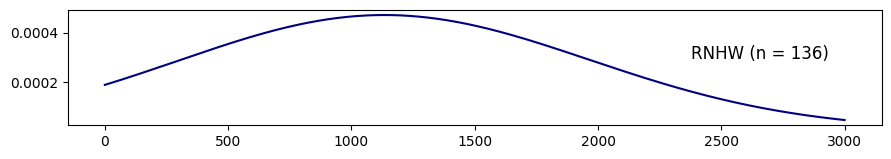

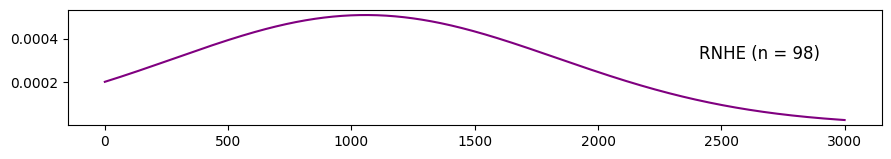

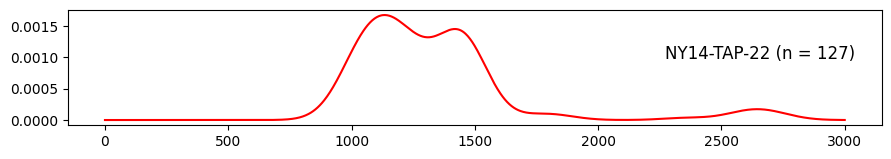

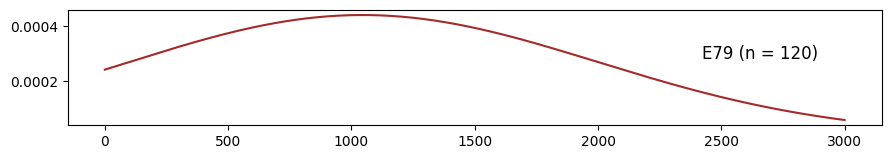

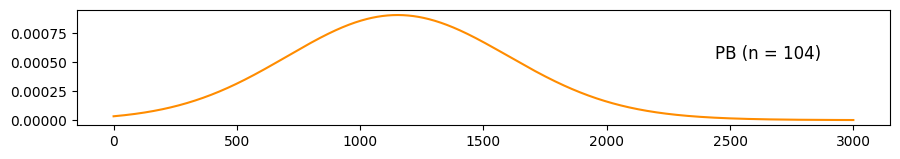

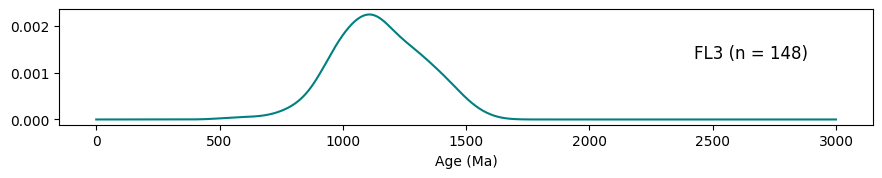

In [123]:
# kde_func call with c = 2.4
kde_func('ForAgeCalc.xlsx', 10.5, 10.5, 2.4, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], False, True)

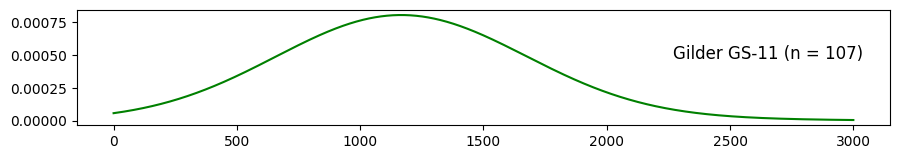

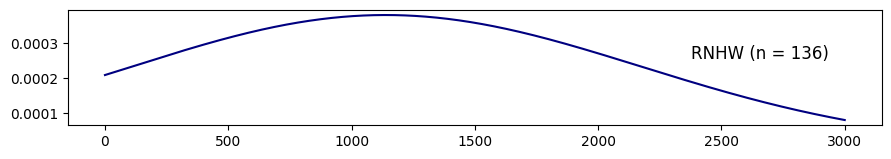

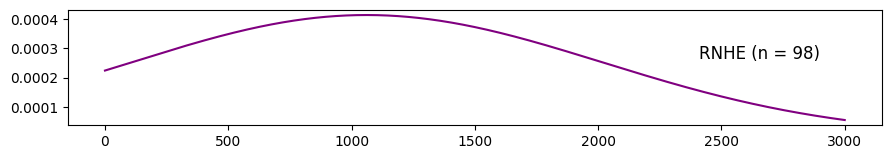

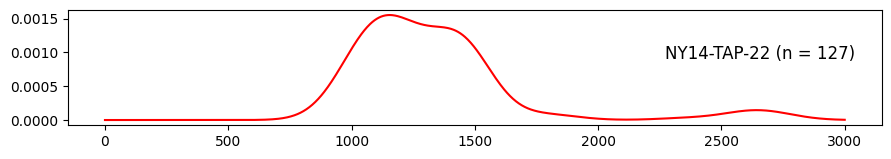

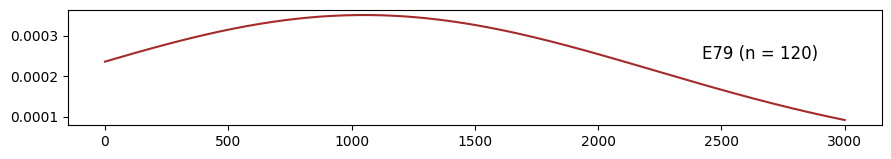

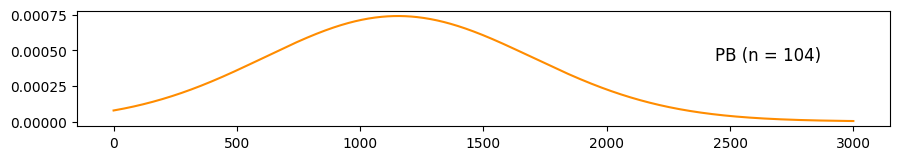

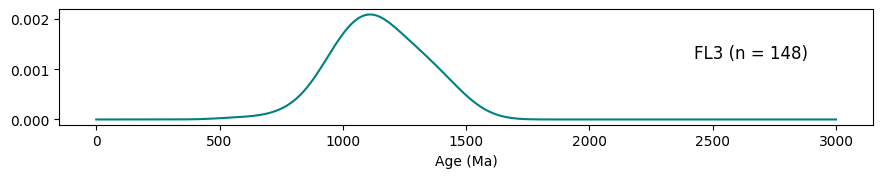

In [124]:
# kde_func call with c = 3
kde_func('ForAgeCalc.xlsx', 10.5, 10.5, 3, 0, 3000, 1000, 50, ['green', 'navy', 'purple', 'red', 'brown', 'darkorange', 'teal'], False, True)

In [50]:
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dataset
data = pd.read_excel('ForAgeCalc.xlsx', usecols=['RNHW']).dropna()
data = pd.to_numeric(data['RNHW'])

# x-value range for plotting KDEs
x_range = np.linspace(0,3000,1000)

# iterate over bandwidth values
def kde_new(info, h, the_color, the_alpha, title):
    total_sum = np.zeros_like(x_range)
    for i, xi in enumerate(data):
        total_sum += K((x_range - xi) / h)
    y_range = total_sum/(h*len(data))
    plt.plot(x_range, y_range, color=the_color)
    plt.fill_between(x_range, y_range, color=the_color, alpha=the_alpha)
    plt.xlabel('Age (Ma)')
    plt.ylabel('Density')
    plt.title(title)
    plt.show()

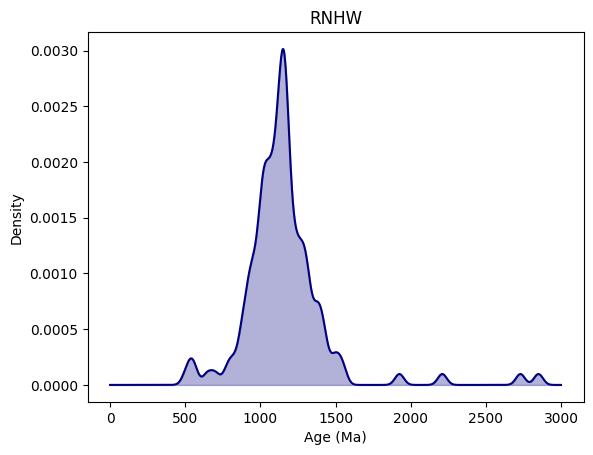

In [51]:
kde_new(data, 30, 'navy', 0.3, 'RNHW')